# Authorship Detection

In [102]:
books_df = pd.read_csv('AuthorsForNLP.csv', header = 1)
books_df = books_df.loc[:,:'Genre (optional) ']
# books_df = books_df.reindex(books_df.index.drop(1))
books_df

,BOOK,ID,Author,Length,Sex,Period,Genre (optional)
0,Two Treatises on Government,7370.0,John Locke,87920.0,Male,Enlightenment,Political Philosophy
1,A Vindication of the Rights of Woman,3420.0,Mary Wollstonecraft,141520.0,Female,Enlightenment,Political Philosophy
2,The Scarlet Letter,33.0,Nathaniel Hawthorne,NaN,Male,American Gothic / Romantic,NaN
3,Frankenstein,84.0,Mary Shelley,NaN,Female,American Gothic / Romantic,Horror
4,A Tale of Two Cities,98.0,Charles Dickens,NaN,Male,Victorian,NaN
5,Pride and Prejudice,1342.0,Jane Austin,NaN,Female,Victorian,NaN
6,Walden,NaN,Henry David Thoreau,NaN,Male,Transcendentalism,NaN
7,Summer on the Lakes,NaN,Margaret Fuller,NaN,Female,Transcendentalism,NaN
8,The Call of the Wild and White Fang,NaN,Jack London,91945.0,Male,Naturalism,NaN
9,The House of Mirth,NaN,Edith Wharton,98600.0,Female,Naturalism,NaN


In [1]:
import pandas as pd
import numpy as np
import gensim
import os
from gensim.models.doc2vec import *
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import colorlover as cl
from IPython.display import HTML
from keras import regularizers
from keras.layers import Dropout
from keras import optimizers
import ipywidgets as widgets
from collections import Counter
import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.
/anaconda3/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning:

compiletime version 3.6 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.5



In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
*The raw code for this Jupyter notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
df = pd.read_csv(os.getcwd() + '/' + '250Paragraphs_150Words.csv', index_col = 0)

In [3]:
df.head()

,text,author,sex,period
0,fell together as modest people will in the tai...,MarkTwain,male,realism
1,that he ran away as he were wood demented for ...,MarkTwain,male,realism
2,had ye not been therefore to yield us unto him...,MarkTwain,male,realism
3,the advantage so i judged it best to humor him...,MarkTwain,male,realism
4,girls were always naked but nobody seemed to k...,MarkTwain,male,realism


In [4]:
authors = list(set((df['author'])))

In [5]:
# split 
def split_by_authors():
    df_split ={}
    for author in authors:
        df_ = df[df['author'] == author]
        df_split[author] = df_
    return df_split

df_by_authors = split_by_authors()

In [6]:
train_set_df = pd.DataFrame(columns=list(df.columns))
test_set_df = pd.DataFrame(columns=list(df.columns))
validation_set_df = pd.DataFrame(columns=list(df.columns))
for author in authors:
    train_set = df_by_authors[author].sample(int((len(df_by_authors[author]))*0.7))
    test_val_set = df_by_authors[author].drop(train_set.index)
    validation_set = test_val_set.sample(int((len(df_by_authors[author]))*0.1))
    test_set = test_val_set.drop(validation_set.index)
    train_set_df = pd.concat([train_set_df,train_set])
    test_set_df = pd.concat([test_set_df,test_set])
    validation_set_df = pd.concat([validation_set_df,validation_set])

In [7]:
# resetting the index
train_set_df = train_set_df.reset_index()
test_set_df = test_set_df.reset_index()
validation_set_df = validation_set_df.reset_index()

In [8]:
# Create TaggedDocument objects for train_corpus
train_corpus = []
for i in range(0, len(train_set_df)):
    doc = TaggedDocument(train_set_df['text'][i].split(), [train_set_df['author'][i], 
                                                            train_set_df['period'][i], 
                                                            train_set_df['sex'][i]])   
    train_corpus.append(doc)

In [9]:
# Create corpus objects for test_corpus
test_corpus = []
for i in range(0, len(test_set_df)):
    doc = test_set_df['text'][i].split()
    test_corpus.append(doc)
    
# Create corpus objects for val_corpus
val_corpus = []
for i in range(0, len(validation_set_df)):
    doc = validation_set_df['text'][i].split()
    val_corpus.append(doc)

In [10]:
# Declare gyperparamters 
vec_size = 20
min_count = 2
epochs = 20
alpha = 0.025
min_alpha = 0.025

In [11]:
# Doc2Vec - initializing the model

model = Doc2Vec(vector_size=vec_size,
                min_count=min_count,
                epochs=epochs,
                alpha = alpha,
                min_alpha = min_alpha)

model.build_vocab(train_corpus)

%time model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)

CPU times: user 17.1 s, sys: 924 ms, total: 18.1 s
Wall time: 9.48 s


In [12]:
len(model.docvecs)
# should be 23
# two for gender, seven for periods, and fourteen for authors 

23

In [19]:
test_set_df.loc[60]

index                                                  1054
text      the party which had been suggested a few night...
author                                        VirginiaWoolf
sex                                                  female
period                                      early_modernism
Name: 60, dtype: object

In [20]:
inferred_vector = model.infer_vector(test_corpus[60])
sims = model.docvecs.most_similar([inferred_vector])
print(inferred_vector)
sims

[ 0.39552853  0.37767652  0.7766568   0.3444385  -0.4851894  -0.2639596
  0.43216866  1.9154274  -0.24003392 -1.4320052  -0.28917027  0.31995183
  0.07864778 -1.0596488   0.37871018  0.6742162  -1.585403   -1.143115
  1.3028474   1.3090353 ]


[('female', 0.7585808038711548),
 ('male', 0.6273422241210938),
 ('early_modernism', 0.34724321961402893),
 ('realism', 0.2911320924758911),
 ('EdithWharton', 0.2874087691307068),
 ('JaneAustin', 0.28167134523391724),
 ('HenryDavidThoreau', 0.23015323281288147),
 ('VirginiaWoolf', 0.2021331638097763),
 ('naturalism', 0.19752921164035797),
 ('transcendentalism', 0.18988941609859467)]

In [15]:
def derive_score_train(df, corpus):
    score_list = {}
    for i in range(0, len(test_set_df)):
        cos_sims = []
        inferred_vector = model.infer_vector(corpus[i].words)
        sims = dict(model.docvecs.most_similar([inferred_vector]))
        if test_set_df.iloc[i]['author'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['author']])
        if test_set_df.iloc[i]['sex'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['sex']])
        if test_set_df.iloc[i]['period'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['period']])
        total_score = sum(cos_sims)
        score_list[test_set_df.iloc[i]['index']] = total_score/3
    return score_list

def derive_score_test(df, corpus):
    score_list = {}
    for i in range(0, len(test_set_df)):
        cos_sims = []
        inferred_vector = model.infer_vector(corpus[i])
        sims = dict(model.docvecs.most_similar([inferred_vector]))
        if test_set_df.iloc[i]['author'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['author']])
        if test_set_df.iloc[i]['sex'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['sex']])
        if test_set_df.iloc[i]['period'] in list(sims.keys()):
            cos_sims.append(sims[test_set_df.iloc[i]['period']])
        total_score = sum(cos_sims)
        score_list[test_set_df.iloc[i]['index']] = total_score/3
    return score_list

score_list_train = derive_score_train(train_set_df, train_corpus)
score_list_test = derive_score_test(test_set_df, test_corpus)

In [16]:
score_avg_train = sum(score_list_train.values()) / len(score_list_train)
print('calculated accuracy score for train set is ' + str(round(score_avg_train*100, 2)) + '%')

score_avg_test = sum(score_list_test.values()) / len(score_list_test)
print('calculated accuracy score for test set is ' + str(round(score_avg_test*100, 2)) + '%')

calculated accuracy score for train set is 28.84%
calculated accuracy score for test set is 42.18%


In [17]:
# calcurate the weighted score

weighted_score_list_test = {}  # for test set
for i in range(0, len(test_set_df)):
    cos_sims = []
    inferred_vector = model.infer_vector(test_corpus[i])
    sims = dict(model.docvecs.most_similar([inferred_vector]))
    if test_set_df.iloc[i]['author'] in list(sims.keys()):
        cos_sims.append(sims[test_set_df.iloc[i]['author']]*(23-(list(sims.keys()).index(test_set_df.iloc[i]['author']))))
    if test_set_df.iloc[i]['sex'] in list(sims.keys()):
        cos_sims.append(sims[test_set_df.iloc[i]['sex']]*(23-(list(sims.keys()).index(test_set_df.iloc[i]['sex']))))
    if test_set_df.iloc[i]['period'] in list(sims.keys()):
        cos_sims.append(sims[test_set_df.iloc[i]['period']]*(23-(list(sims.keys()).index(test_set_df.iloc[i]['period']))))
    total_score = sum(cos_sims)
    weighted_score_list_test[test_set_df.iloc[i]['index']] = total_score/(23+22+21)

weighted_score_list_train = {}  # for training set
for i in range(0, len(train_set_df)):
    cos_sims = []
    inferred_vector = model.infer_vector(train_corpus[i].words)
    sims = dict(model.docvecs.most_similar([inferred_vector]))
    if train_set_df.iloc[i]['author'] in list(sims.keys()):
        cos_sims.append(sims[train_set_df.iloc[i]['author']]*(23-(list(sims.keys()).index(train_set_df.iloc[i]['author']))))
    if train_set_df.iloc[i]['sex'] in list(sims.keys()):
        cos_sims.append(sims[train_set_df.iloc[i]['sex']]*(23-(list(sims.keys()).index(train_set_df.iloc[i]['sex']))))
    if train_set_df.iloc[i]['period'] in list(sims.keys()):
        cos_sims.append(sims[train_set_df.iloc[i]['period']]*(23-(list(sims.keys()).index(train_set_df.iloc[i]['period']))))
    total_score = sum(cos_sims)
    weighted_score_list_train[train_set_df.iloc[i]['index']] = total_score/(23+22+21)

In [18]:
weighted_score_avg_train = sum(weighted_score_list_train.values()) / len(weighted_score_list_train)
print('calculated accuracy score for train set is ' + str(round(weighted_score_avg_train*100, 2)) + '%')

weighted_score_avg_test = sum(weighted_score_list_test.values()) / len(weighted_score_list_test)
print('calculated accuracy score for test set is ' + str(round(weighted_score_avg_test*100, 2)) + '%')

calculated accuracy score for train set is 45.37%
calculated accuracy score for test set is 38.8%


In [19]:
# vector representation of all documents in list form (for training set)
doc_vectors = [model.infer_vector(train_corpus[i].words) for i in range(0,len(train_corpus))]

In [20]:
# vector representation of all documents in list form (for validation set)
doc_vectors_val = [model.infer_vector(val_corpus[i]) for i in range(0,len(val_corpus))]

In [21]:
# vector representation of all documents in list form (for test set)
doc_vectors_test = [model.infer_vector(test_corpus[i]) for i in range(0,len(test_corpus))]

In [22]:
# reduce dimensionality to visualize the document vectors 
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(doc_vectors)
doc_vectors_3d = pca.transform(doc_vectors) # transform the vectors to 3d space
explained_variance_ratio = np.cumsum(pca.explained_variance_ratio_)[2]
explained_variance_ratio

0.3235167282174611

In [23]:
df.head()

,text,author,sex,period
0,fell together as modest people will in the tai...,MarkTwain,male,realism
1,that he ran away as he were wood demented for ...,MarkTwain,male,realism
2,had ye not been therefore to yield us unto him...,MarkTwain,male,realism
3,the advantage so i judged it best to humor him...,MarkTwain,male,realism
4,girls were always naked but nobody seemed to k...,MarkTwain,male,realism


In [24]:
# create author, gender, period dictionaries for mapping 
num = list(range(0,len(authors)))
author_num = dict(zip(authors, num))

genders = list(set((df['sex'])))
num_gen = list(range(0,len(genders)))
sex_num = dict(zip(genders, num_gen))

periods = list(set((df['period'])))
num_period = list(range(0,len(periods)))
period_num = dict(zip(periods, num_period))

In [25]:
# Dataframes for plotting
doc_vectors_3d = pd.DataFrame(doc_vectors_3d)  

# by author
authors_df = pd.DataFrame([train_corpus[i].tags[0] for i in range(0, len(train_corpus))])
doc_vectors_3d_with_author =pd.concat([doc_vectors_3d,authors_df], axis = 1)
doc_vectors_3d_with_author.columns = ['x','y','z','author']
doc_vectors_3d_with_author['author'] = doc_vectors_3d_with_author['author'].map(author_num)

# by gender
gender_df = pd.DataFrame([train_corpus[i].tags[2] for i in range(0, len(train_corpus))])
doc_vectors_3d_with_gender =pd.concat([doc_vectors_3d,gender_df], axis = 1)
doc_vectors_3d_with_gender.columns = ['x','y','z','sex']
doc_vectors_3d_with_gender['sex'] = doc_vectors_3d_with_gender['sex'].map(sex_num)

# by period
period_df = pd.DataFrame([train_corpus[i].tags[1] for i in range(0, len(train_corpus))])
doc_vectors_3d_with_period =pd.concat([doc_vectors_3d,period_df], axis = 1)
doc_vectors_3d_with_period.columns = ['x','y','z','period']
doc_vectors_3d_with_period['period'] = doc_vectors_3d_with_period['period'].map(period_num)

In [31]:
authors_df.head()

,0
0,FScottFitzgerald
1,FScottFitzgerald
2,FScottFitzgerald
3,FScottFitzgerald
4,FScottFitzgerald


In [32]:
doc_vectors_3d.head()

,0,1,2
0,-2.062581,0.289837,-0.059609
1,-1.446138,0.463260,0.169613
2,-0.914940,0.696528,-0.890136
3,-0.616604,0.433110,0.254315
4,-1.251596,0.642279,-0.639162


In [34]:
doc_vectors_3d_with_author.head()

,x,y,z,author
0,-2.062581,0.289837,-0.059609,0
1,-1.446138,0.463260,0.169613,0
2,-0.914940,0.696528,-0.890136,0
3,-0.616604,0.433110,0.254315,0
4,-1.251596,0.642279,-0.639162,0


In [26]:
def color_map(category):
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    jump = 256//len(category)
    cmaplist_ = [cmaplist[jump*i] for i in range(0,len(category))]
    return cmaplist_

cmap_author = color_map(authors)
cmap_sex = color_map(genders)
cmap_periods = color_map(periods)

In [27]:
# by author
traces_for_plot = []
for key, value in author_num.items():
    df = doc_vectors_3d_with_author[doc_vectors_3d_with_author['author'] == value]
    traces_for_plot.append(df)

traces_author = []
for trace in traces_for_plot:
    trace1 = go.Scatter3d(
    x = trace['x'],
    y = trace['y'],
    z = trace['z'],
    mode='markers',
    name = authors[trace['author'].values[0]],
    marker=dict(
        size=5,
        color= 'rgba' + str(cmap_author[(trace['author'].values[0])]),
    )
    )
    traces_author.append(trace1)

layout = go.Layout(showlegend=True)
# # Make a figure object
fig = go.Figure(data= traces_author, layout = layout)

# Send to Plotly and show in notebook
iplot(fig, filename='test1')

In [28]:
# by gender
traces_for_plot_sex = []
for key, value in sex_num.items():
    df = doc_vectors_3d_with_gender[doc_vectors_3d_with_gender['sex'] == value]
    traces_for_plot_sex.append(df)

traces_sex = []
for trace in traces_for_plot_sex:
    trace1 = go.Scatter3d(
    x = trace['x'],
    y = trace['y'],
    z = trace['z'],
    mode='markers',
    name = genders[trace['sex'].values[0]],
    marker=dict(
        size=5,
        color= 'rgba' + str(cmap_sex[(trace['sex'].values[0])]),
    )
    )
    traces_sex.append(trace1)

layout = go.Layout(showlegend=True)
# # Make a figure object
fig = go.Figure(data= traces_sex, layout = layout)

# Send to Plotly and show in notebook
iplot(fig, filename='test1')

In [29]:
# by period
traces_for_plot_period = []
for key, value in period_num.items():
    df = doc_vectors_3d_with_period[doc_vectors_3d_with_period['period'] == value]
    traces_for_plot_period.append(df)

traces_period = []
for trace in traces_for_plot_period:
    trace1 = go.Scatter3d(
    x = trace['x'],
    y = trace['y'],
    z = trace['z'],
    mode='markers',
    name = periods[trace['period'].values[0]],
    marker=dict(
        size=5,
        color= 'rgba' + str(cmap_periods[(trace['period'].values[0])]),
    )
    )
    traces_period.append(trace1)

layout = go.Layout(showlegend=True)
# # Make a figure object
fig = go.Figure(data= traces_period, layout = layout)

# Send to Plotly and show in notebook
iplot(fig, filename='test1')

### Multilayer Perceptrons
#### Gender Classification (binary)

In [41]:
import keras
from keras.models import Sequential
from keras.layers import Dense

In [42]:
# create a dataframe (gender) for CNN - train set 
doc_vec_df = pd.DataFrame(doc_vectors)
gender_df.columns = ['sex']
doc_vec_df_with_gender = pd.concat([doc_vec_df,gender_df], axis = 1)
doc_vec_df_with_gender['sex'] = doc_vec_df_with_gender['sex'].map(sex_num)
X_train = doc_vec_df_with_gender.drop(['sex'], axis = 1)
y_train = doc_vec_df_with_gender.sex

In [43]:
# create a dataframe (gender) for CNN - validation set
doc_vec_df_val_set = pd.DataFrame(doc_vectors_val)
gender_df_val_set = pd.DataFrame(validation_set_df['sex'])
gender_df_val_set.columns = ['sex']
doc_vec_df_val_set_w_gender = pd.concat([doc_vec_df_val_set,gender_df_val_set], axis = 1)
doc_vec_df_val_set_w_gender['sex'] = doc_vec_df_val_set_w_gender['sex'].map(sex_num)
X_val = doc_vec_df_val_set_w_gender.drop(['sex'], axis = 1)
y_val = doc_vec_df_val_set_w_gender.sex

In [44]:
# create a dataframe (gender) for CNN - test set
doc_vec_df_test_set = pd.DataFrame(doc_vectors_test)
gender_df_test_set = pd.DataFrame(test_set_df['sex'])
gender_df_test_set.columns = ['sex']
doc_vec_df_test_set_w_gender = pd.concat([doc_vec_df_test_set,gender_df_test_set], axis = 1)
doc_vec_df_test_set_w_gender['sex'] = doc_vec_df_test_set_w_gender['sex'].map(sex_num)
X_test = doc_vec_df_test_set_w_gender.drop(['sex'], axis = 1)
y_test = doc_vec_df_test_set_w_gender.sex

In [45]:
y_train = keras.utils.to_categorical(y_train, 2)
y_val = keras.utils.to_categorical(y_val, 2)
y_test = keras.utils.to_categorical(y_test, 2)

In [46]:
sigmoid_model = Sequential()
sigmoid_model.add(Dense(100, activation='relu', input_shape=(20,)))
sigmoid_model.add(Dense(50, activation='relu'))
sigmoid_model.add(Dense(2, activation='sigmoid'))
sigmoid_model.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [47]:
model_val = sigmoid_model.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=1, validation_data=(X_val, y_val))

Train on 2450 samples, validate on 350 samples
Epoch 1/100
2450/2450 [==============================] - 0s 168us/step - loss: 0.6652 - acc: 0.6194 - val_loss: 0.5838 - val_acc: 0.7486
Epoch 2/100
2450/2450 [==============================] - 0s 52us/step - loss: 0.4459 - acc: 0.8531 - val_loss: 0.4847 - val_acc: 0.7914
Epoch 3/100
2450/2450 [==============================] - 0s 52us/step - loss: 0.3120 - acc: 0.9190 - val_loss: 0.4258 - val_acc: 0.8129
Epoch 4/100
2450/2450 [==============================] - 0s 54us/step - loss: 0.2321 - acc: 0.9384 - val_loss: 0.3974 - val_acc: 0.8114
Epoch 5/100
2450/2450 [==============================] - 0s 51us/step - loss: 0.1841 - acc: 0.9504 - val_loss: 0.3843 - val_acc: 0.8186
Epoch 6/100
2450/2450 [==============================] - 0s 52us/step - loss: 0.1533 - acc: 0.9590 - val_loss: 0.3789 - val_acc: 0.8243
Epoch 7/100
2450/2450 [==============================] - 0s 52us/step - loss: 0.1323 - acc: 0.9643 - val_loss: 0.3756 - val_acc: 0.8229


In [48]:
results_train = sigmoid_model.evaluate(X_train, y_train)

2450/2450 [==============================] - 0s 17us/step


In [49]:
results_train = sigmoid_model.evaluate(X_train, y_train)
results_test = sigmoid_model.evaluate(X_test, y_test)

700/700 [==============================] - 0s 19us/step


In [50]:
print(results_train)
results_train

[0.011046921581086912, 0.996938775510204]


[0.011046921581086912, 0.996938775510204]

In [51]:
history = model_val.history
history.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

<IPython.core.display.Javascript object>


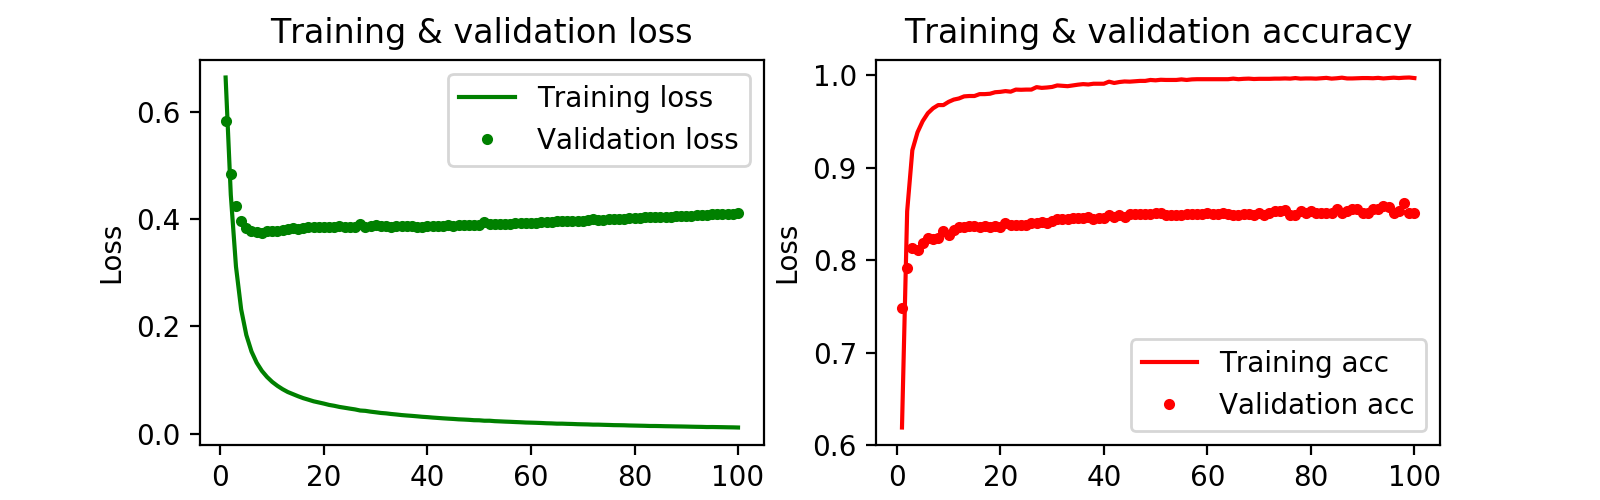

In [52]:
%matplotlib notebook
loss_values = history['loss']
val_loss_values = history['val_loss']
acc_values = history['acc'] 
val_acc_values = history['val_acc']
epochs = range(1, len(loss_values) + 1)

plt.figure(figsize = (8,2.5))
plt.subplot(121)
plt.plot(epochs, loss_values, 'g', label='Training loss')
plt.plot(epochs, val_loss_values, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Period Classification (multi-class)

In [53]:
# create a dataframe (period) for CNN - train set 
period_df.columns = ['period']
doc_vec_df_with_period = pd.concat([doc_vec_df,period_df], axis = 1)
doc_vec_df_with_period['period'] = doc_vec_df_with_period['period'].map(period_num)
X_train_period = doc_vec_df_with_period.drop(['period'], axis = 1)
y_train_period = doc_vec_df_with_period.period

In [54]:
# create a dataframe (period) for CNN - validation set
period_df_val_set = pd.DataFrame(validation_set_df['period'])
period_df_val_set.columns = ['period']
doc_vec_df_val_set_w_period = pd.concat([doc_vec_df_val_set,period_df_val_set], axis = 1)
doc_vec_df_val_set_w_period['period'] = doc_vec_df_val_set_w_period['period'].map(period_num)
X_val_period = doc_vec_df_val_set_w_period.drop(['period'], axis = 1)
y_val_period = doc_vec_df_val_set_w_period.period

In [55]:
# create a dataframe (period) for CNN - test set
period_df_test_set = pd.DataFrame(test_set_df['period'])
period_df_test_set.columns = ['period']
doc_vec_df_test_set_w_period = pd.concat([doc_vec_df_test_set,period_df_test_set], axis = 1)
doc_vec_df_test_set_w_period['period'] = doc_vec_df_test_set_w_period['period'].map(period_num)
X_test_period = doc_vec_df_test_set_w_period.drop(['period'], axis = 1)
y_test_period = doc_vec_df_test_set_w_period.period

In [56]:
y_train_period = keras.utils.to_categorical(y_train_period, len(period_num))
y_val_period = keras.utils.to_categorical(y_val_period, len(period_num))
y_test_period = keras.utils.to_categorical(y_test_period, len(period_num))

In [57]:
softmax_model_period = Sequential()
softmax_model_period.add(Dense(100, activation='relu', input_shape=(20,)))
softmax_model_period.add(Dense(50, activation='relu'))
softmax_model_period.add(Dense(2, activation='softmax'))
softmax_model_period.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [58]:
softmax_model_period.fit(X_train, y_train, epochs= 100, batch_size=32, verbose=1, validation_data=(X_val, y_val))

Train on 2450 samples, validate on 350 samples
Epoch 1/100
2450/2450 [==============================] - 0s 145us/step - loss: 0.4224 - acc: 0.8322 - val_loss: 0.4685 - val_acc: 0.7800
Epoch 2/100
2450/2450 [==============================] - 0s 56us/step - loss: 0.2030 - acc: 0.9355 - val_loss: 0.4276 - val_acc: 0.7857
Epoch 3/100
2450/2450 [==============================] - 0s 63us/step - loss: 0.1457 - acc: 0.9498 - val_loss: 0.4194 - val_acc: 0.8086
Epoch 4/100
2450/2450 [==============================] - 0s 54us/step - loss: 0.1192 - acc: 0.9584 - val_loss: 0.4181 - val_acc: 0.8143
Epoch 5/100
2450/2450 [==============================] - 0s 52us/step - loss: 0.1031 - acc: 0.9645 - val_loss: 0.4132 - val_acc: 0.8114
Epoch 6/100
2450/2450 [==============================] - 0s 51us/step - loss: 0.0918 - acc: 0.9706 - val_loss: 0.4105 - val_acc: 0.8200
Epoch 7/100
2450/2450 [==============================] - 0s 67us/step - loss: 0.0833 - acc: 0.9747 - val_loss: 0.4073 - val_acc: 0.8200


#### Doc2Vec by Unique ID
- instead of using the target labels (gender, author, etc..), use unique id as label 
- this is going to give us the vector representation of each document

In [59]:
# Create TaggedDocument objects for train_corpus_unique_id
train_corpus_unique_id = []
for i in range(0, len(train_set_df)):
    doc = TaggedDocument(train_set_df['text'][i].split(), [i])   
    train_corpus_unique_id.append(doc)

In [60]:
model_unique_id = Doc2Vec(vector_size=vec_size,
                min_count=min_count,
                epochs=epochs,
                alpha = alpha,
                min_alpha = min_alpha)

model_unique_id.build_vocab(train_corpus_unique_id)

%time model_unique_id.train(train_corpus_unique_id, total_examples = model.corpus_count, epochs = model.epochs)

CPU times: user 15.8 s, sys: 1.04 s, total: 16.8 s
Wall time: 7.26 s


In [61]:
ranks = []
second_ranks = []
for doc_id in range(len(train_corpus_unique_id)):
    inferred_vector = model_unique_id.infer_vector(train_corpus_unique_id[doc_id].words)
    sims = model_unique_id.docvecs.most_similar([inferred_vector], topn=len(model_unique_id.docvecs))
    rank = [docid for docid, sim in sims].index(doc_id)
    ranks.append(rank)
    #see how many it got correct and how many it didn't 
counter = Counter(ranks)

In [62]:
# accuracy 
counter 

Counter({0: 2400,
         3: 3,
         1: 33,
         11: 1,
         4: 2,
         6: 2,
         14: 1,
         7: 1,
         16: 1,
         8: 1,
         2: 5})

In [63]:
doc_vectors_unique_id = [model_unique_id.infer_vector(train_corpus_unique_id[i].words) for i in range(0,len(train_corpus_unique_id))]
doc_vectors_unique_id_df = pd.DataFrame(doc_vectors_unique_id)

In [64]:
train_set_labels = train_set_df[['author', 'sex', 'period']]

In [65]:
# reduce dimensionality to visualize the document vectors 
pca_unique = PCA(n_components = 3)
pca_unique.fit(doc_vectors_unique_id)
doc_vectors_3d_unique_id = pca_unique.transform(doc_vectors_unique_id) # transform the vectors to 3d space
explained_variance_ratio_unique = np.cumsum(pca_unique.explained_variance_ratio_)[2]
explained_variance_ratio_unique

0.3858650756393235

In [66]:
doc_vectors_unique_id_3d_df = pd.DataFrame(doc_vectors_3d_unique_id)
doc_vectors_unique_id_3d_df.columns = ['x', 'y', 'z']
doc_vec_unique_id_df = pd.concat([doc_vectors_unique_id_3d_df, train_set_labels], axis = 1)
doc_vec_unique_id_df['author'] = doc_vec_unique_id_df['author'].map(author_num)
doc_vec_unique_id_df['sex'] = doc_vec_unique_id_df['sex'].map(sex_num)
doc_vec_unique_id_df['period'] = doc_vec_unique_id_df['period'].map(period_num)

doc_vectors_unique_id_df = pd.concat([doc_vectors_unique_id_df, train_set_labels], axis = 1)

In [67]:
def color_map(category):
    cmap = plt.cm.viridis
    cmaplist = [cmap(i) for i in range(cmap.N)]
    jump = 256//len(category)
    cmaplist_ = [cmaplist[jump*i] for i in range(0,len(category))]
    return cmaplist_

cmap_author = color_map(authors)
cmap_sex = color_map(genders)
cmap_periods = color_map(periods)

In [84]:
from IPython.html.widgets import interact
def update_plot(w):
    if w == 'author':
        traces_for_plot_unique = []
        for key, value in author_num.items():
            df = doc_vec_unique_id_df[doc_vec_unique_id_df['author'] == value]
            traces_for_plot_unique.append(df)

        traces_unique_author = []
        for trace in traces_for_plot_unique:
            trace1 = go.Scatter3d(
            x = trace['x'],
            y = trace['y'],
            z = trace['z'],
            mode='markers',
            name = authors[trace['author'].values[0]],
            marker=dict(
                size=5,
                color= 'rgba' + str(cmap_author[(trace['author'].values[0])]),
            )
            )
            traces_unique_author.append(trace1)
        layout = go.Layout(showlegend=True)
        fig = go.Figure(data= traces_unique_author, layout = layout)
        iplot(fig, filename='test1')
    if w == 'gender':
        traces_for_plot_unique_sex = []
        for key, value in sex_num.items():
            df = doc_vec_unique_id_df[doc_vec_unique_id_df['sex'] == value]
            traces_for_plot_unique_sex.append(df)

        traces_unique_gender = []
        for trace in traces_for_plot_unique_sex:
            trace1 = go.Scatter3d(
            x = trace['x'],
            y = trace['y'],
            z = trace['z'],
            mode='markers',
            name = genders[trace['sex'].values[0]],
            marker=dict(
                size=5,
                color= 'rgba' + str(cmap_sex[(trace['sex'].values[0])]),
            )
            )
            traces_unique_gender.append(trace1)

        layout = go.Layout(showlegend=True)
        # # Make a figure object
        fig = go.Figure(data= traces_unique_gender, layout = layout)

        # Send to Plotly and show in notebook
        iplot(fig, filename='test1')
    if w == 'time period':
        traces_for_plot_unique_period = []
        for key, value in period_num.items():
            df = doc_vec_unique_id_df[doc_vec_unique_id_df['period'] == value]
            traces_for_plot_unique_period.append(df)

        traces_unique_period = []
        for trace in traces_for_plot_unique_period:
            trace1 = go.Scatter3d(
            x = trace['x'],
            y = trace['y'],
            z = trace['z'],
            mode='markers',
            name = periods[trace['period'].values[0]],
            marker=dict(
                size=5,
                color= 'rgba' + str(cmap_periods[(trace['period'].values[0])]),
            )
            )
            traces_unique_period.append(trace1)

        layout = go.Layout(showlegend=True)
        # # Make a figure object
        fig = go.Figure(data= traces_unique_period, layout = layout)

        # Send to Plotly and show in notebook
        iplot(fig, filename='test1')

w = widgets.Dropdown(
    options= ['author','gender','time period'],
    value='author',
    description='Category:',
    disabled=False)
# w.observe(update_plot)
interact(update_plot, w=w)

interactive(children=(Dropdown(description='Category:', options=('author', 'gender', 'time period'), value='au…

<function __main__.update_plot(w)>

In [58]:
# by author
traces_for_plot_unique = []
for key, value in author_num.items():
    df = doc_vec_unique_id_df[doc_vec_unique_id_df['author'] == value]
    traces_for_plot_unique.append(df)

traces_unique_author = []
for trace in traces_for_plot_unique:
    trace1 = go.Scatter3d(
    x = trace['x'],
    y = trace['y'],
    z = trace['z'],
    mode='markers',
    name = authors[trace['author'].values[0]],
    marker=dict(
        size=5,
        color= 'rgba' + str(cmap_author[(trace['author'].values[0])]),
    )
    )
    traces_unique_author.append(trace1)

layout = go.Layout(showlegend=True)
# # Make a figure object
fig = go.Figure(data= traces_unique_author, layout = layout)

# Send to Plotly and show in notebook
iplot(fig, filename='test1')

In [59]:
# by gender
traces_for_plot_unique_sex = []
for key, value in sex_num.items():
    df = doc_vec_unique_id_df[doc_vec_unique_id_df['sex'] == value]
    traces_for_plot_unique_sex.append(df)

traces_unique_gender = []
for trace in traces_for_plot_unique_sex:
    trace1 = go.Scatter3d(
    x = trace['x'],
    y = trace['y'],
    z = trace['z'],
    mode='markers',
    name = genders[trace['sex'].values[0]],
    marker=dict(
        size=5,
        color= 'rgba' + str(cmap_sex[(trace['sex'].values[0])]),
    )
    )
    traces_unique_gender.append(trace1)

layout = go.Layout(showlegend=True)
# # Make a figure object
fig = go.Figure(data= traces_unique_gender, layout = layout)

# Send to Plotly and show in notebook
iplot(fig, filename='test1')

In [60]:
# by period
traces_for_plot_unique_period = []
for key, value in period_num.items():
    df = doc_vec_unique_id_df[doc_vec_unique_id_df['period'] == value]
    traces_for_plot_unique_period.append(df)

traces_unique_period = []
for trace in traces_for_plot_unique_period:
    trace1 = go.Scatter3d(
    x = trace['x'],
    y = trace['y'],
    z = trace['z'],
    mode='markers',
    name = periods[trace['period'].values[0]],
    marker=dict(
        size=5,
        color= 'rgba' + str(cmap_periods[(trace['period'].values[0])]),
    )
    )
    traces_unique_period.append(trace1)

layout = go.Layout(showlegend=True)
# # Make a figure object
fig = go.Figure(data= traces_unique_period, layout = layout)

# Send to Plotly and show in notebook
iplot(fig, filename='test1')

In [64]:
# doc_vectors_unique_id_df.to_csv('document_vectors_df.csv')

#### MLP for Unique-ID Vectors

In [65]:
# create a dataframe (gender) for CNN - train set 
doc_vectors_unique_id_df['sex'] = doc_vectors_unique_id_df['sex'].map(sex_num)
X_train_unique_id = doc_vectors_unique_id_df.drop(['author', 'sex', 'period'], axis = 1)
y_train_unique_id = doc_vectors_unique_id_df.sex

In [66]:
# vector representation of all documents in list form (for validation set)
doc_vectors_val_unique = [model_unique_id.infer_vector(val_corpus[i]) for i in range(0,len(val_corpus))]
# vector representation of all documents in list form (for test set)
doc_vectors_test_unique = [model_unique_id.infer_vector(test_corpus[i]) for i in range(0,len(test_corpus))]

In [67]:
# create a dataframe (gender) for CNN - validation set
doc_vec_df_unique_id_val_set = pd.DataFrame(doc_vectors_val_unique)
gender_df_val_set_unique = pd.DataFrame(validation_set_df['sex'])
gender_df_val_set_unique.columns = ['sex']
doc_vec_df_val_set_w_gender_unique = pd.concat([doc_vec_df_unique_id_val_set,gender_df_val_set_unique], axis = 1)
doc_vec_df_val_set_w_gender_unique['sex'] = doc_vec_df_val_set_w_gender_unique['sex'].map(sex_num)
X_val_unique = doc_vec_df_val_set_w_gender_unique.drop(['sex'], axis = 1)
y_val_unique = doc_vec_df_val_set_w_gender_unique.sex

# create a dataframe (gender) for CNN - test set
doc_vec_df_test_set_unique = pd.DataFrame(doc_vectors_test_unique)
gender_df_test_set_unique = pd.DataFrame(test_set_df['sex'])
gender_df_test_set_unique.columns = ['sex']
doc_vec_df_test_set_w_gender_unique = pd.concat([doc_vec_df_test_set_unique,gender_df_test_set_unique], axis = 1)
doc_vec_df_test_set_w_gender_unique['sex'] = doc_vec_df_test_set_w_gender_unique['sex'].map(sex_num)
X_test_unique = doc_vec_df_test_set_w_gender_unique.drop(['sex'], axis = 1)
y_test_unique = doc_vec_df_test_set_w_gender_unique.sex

In [68]:
y_train_unique_id = keras.utils.to_categorical(y_train_unique_id, 2)
y_val_unique = keras.utils.to_categorical(y_val_unique, 2)
y_test_unique = keras.utils.to_categorical(y_test_unique, 2)

In [69]:
sigmoid_model_unique = Sequential()
sigmoid_model_unique.add(Dense(100, activation='relu', input_shape=(20,)))
sigmoid_model_unique.add(Dense(50, activation='relu'))
sigmoid_model_unique.add(Dense(2, activation='sigmoid'))
sigmoid_model_unique.compile(loss='binary_crossentropy', optimizer='SGD', metrics=['accuracy'])

In [70]:
model_unique = sigmoid_model_unique.fit(X_train_unique_id, y_train_unique_id, epochs= 100, batch_size=32, verbose=1, validation_data=(X_val_unique, y_val_unique))

Train on 2450 samples, validate on 350 samples
Epoch 1/100
2450/2450 [==============================] - 0s 203us/step - loss: 0.7142 - acc: 0.5118 - val_loss: 0.6837 - val_acc: 0.5529
Epoch 2/100
2450/2450 [==============================] - 0s 55us/step - loss: 0.6626 - acc: 0.6008 - val_loss: 0.6517 - val_acc: 0.6200
Epoch 3/100
2450/2450 [==============================] - 0s 56us/step - loss: 0.6297 - acc: 0.6618 - val_loss: 0.6252 - val_acc: 0.6571
Epoch 4/100
2450/2450 [==============================] - 0s 56us/step - loss: 0.6005 - acc: 0.6963 - val_loss: 0.6024 - val_acc: 0.6743
Epoch 5/100
2450/2450 [==============================] - 0s 50us/step - loss: 0.5748 - acc: 0.7182 - val_loss: 0.5832 - val_acc: 0.6786
Epoch 6/100
2450/2450 [==============================] - 0s 71us/step - loss: 0.5536 - acc: 0.7290 - val_loss: 0.5680 - val_acc: 0.6800
Epoch 7/100
2450/2450 [==============================] - 0s 52us/step - loss: 0.5365 - acc: 0.7359 - val_loss: 0.5566 - val_acc: 0.6929


In [71]:
history_unique_id = model_unique.history

<IPython.core.display.Javascript object>


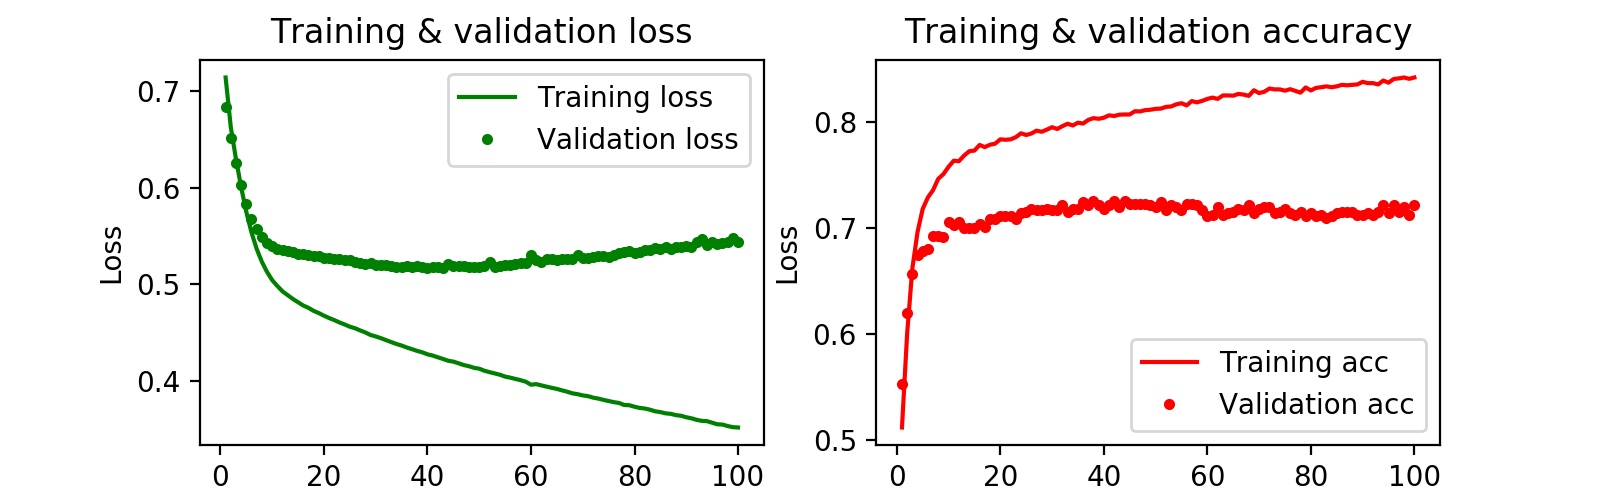

In [100]:
%matplotlib notebook
loss_values_unique_id = history_unique_id['loss']
val_loss_values_unique_id = history_unique_id['val_loss']
acc_values_unique_id = history_unique_id['acc'] 
val_acc_values_unique_id = history_unique_id['val_acc']
epochs_unique_id = range(1, len(loss_values_unique_id) + 1)

plt.figure(figsize = (8,2.5))
plt.subplot(121)
plt.plot(epochs_unique_id, loss_values_unique_id, 'g', label='Training loss')
plt.plot(epochs_unique_id, val_loss_values_unique_id, 'g.', label='Validation loss')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs_unique_id, acc_values_unique_id, 'r', label='Training acc')
plt.plot(epochs_unique_id, val_acc_values_unique_id, 'r.', label='Validation acc')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Early Stopping

In [73]:
model_unique_20 = sigmoid_model_unique.fit(X_train_unique_id, y_train_unique_id, epochs= 20, batch_size=32, verbose=1, validation_data=(X_val_unique, y_val_unique))

Train on 2450 samples, validate on 350 samples
Epoch 1/20
2450/2450 [==============================] - 0s 71us/step - loss: 0.3498 - acc: 0.8439 - val_loss: 0.5453 - val_acc: 0.7143
Epoch 2/20
2450/2450 [==============================] - 0s 72us/step - loss: 0.3492 - acc: 0.8435 - val_loss: 0.5472 - val_acc: 0.7157
Epoch 3/20
2450/2450 [==============================] - 0s 57us/step - loss: 0.3476 - acc: 0.8439 - val_loss: 0.5473 - val_acc: 0.7171
Epoch 4/20
2450/2450 [==============================] - 0s 47us/step - loss: 0.3471 - acc: 0.8435 - val_loss: 0.5515 - val_acc: 0.7129
Epoch 5/20
2450/2450 [==============================] - 0s 50us/step - loss: 0.3458 - acc: 0.8486 - val_loss: 0.5500 - val_acc: 0.7171
Epoch 6/20
2450/2450 [==============================] - 0s 64us/step - loss: 0.3450 - acc: 0.8486 - val_loss: 0.5495 - val_acc: 0.7186
Epoch 7/20
2450/2450 [==============================] - 0s 57us/step - loss: 0.3437 - acc: 0.8482 - val_loss: 0.5504 - val_acc: 0.7186
Epoch 8/

In [74]:
history_early_stop = model_unique_20.history

In [75]:
results_train_unique = sigmoid_model_unique.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique = sigmoid_model_unique.evaluate(X_test_unique, y_test_unique)

700/700 [==============================] - 0s 22us/step


In [76]:
print(results_train_unique)
results_test_unique

[0.3255992078537844, 0.8567346939748647]


[0.4769754161153521, 0.7628571438789368]

<IPython.core.display.Javascript object>


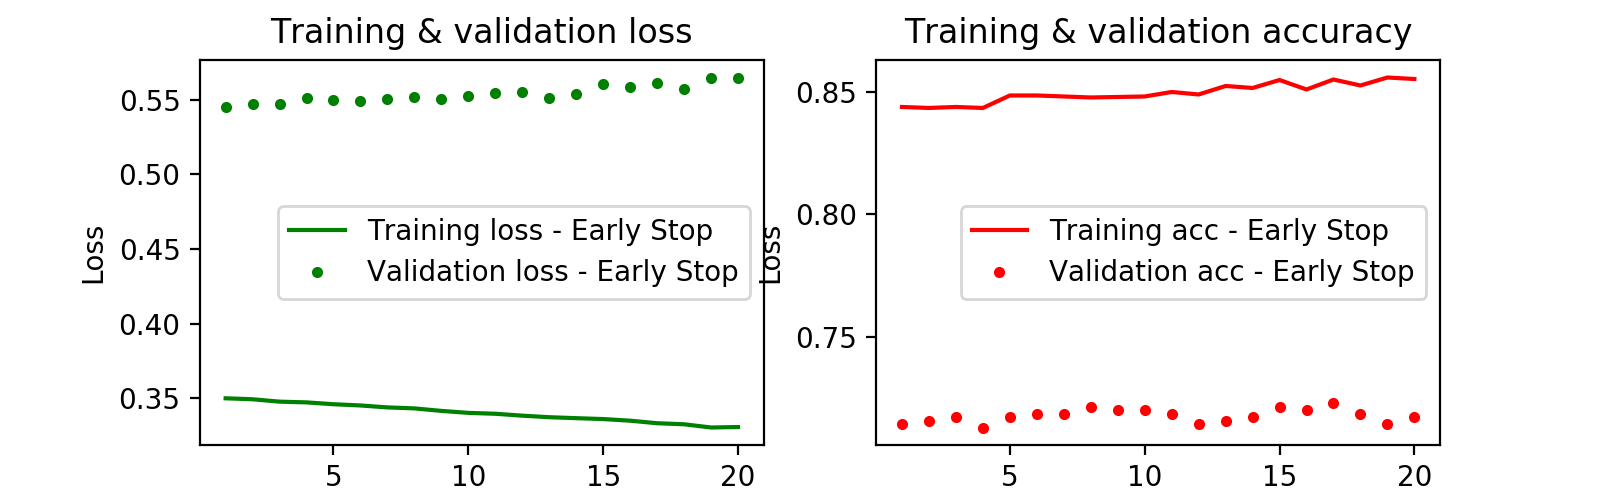

In [101]:
%matplotlib notebook
loss_values_unique_id_20 = history_early_stop['loss']
val_loss_values_unique_id_20 = history_early_stop['val_loss']
acc_values_unique_id_20 = history_early_stop['acc'] 
val_acc_values_unique_id_20 = history_early_stop['val_acc']
epochs_unique_id_20 = range(1, len(loss_values_unique_id_20) + 1)

plt.figure(figsize = (8,2.5))
plt.subplot(121)
plt.plot(epochs_unique_id_20, loss_values_unique_id_20, 'g', label='Training loss - Early Stop')
plt.plot(epochs_unique_id_20, val_loss_values_unique_id_20, 'g.', label='Validation loss - Early Stop')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)

plt.plot(epochs_unique_id_20, acc_values_unique_id_20, 'r', label='Training acc - Early Stop')
plt.plot(epochs_unique_id_20, val_acc_values_unique_id_20, 'r.', label='Validation acc - Early Stop')
plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### L1 Regularization (LASSO)

In [102]:
model_l1 = Sequential()
model_l1.add(Dense(100, activation='relu',kernel_regularizer=regularizers.l1(0.005), input_shape=(20,))) #2 hidden layers
model_l1.add(Dense(50, kernel_regularizer=regularizers.l1(0.005), activation='relu'))
model_l1.add(Dense(2, activation='sigmoid'))

model_l1.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

L1_model = model_l1.fit(X_train_unique_id, y_train_unique_id,
                    epochs=100,
                    batch_size=32,
                    verbose=0,
                    validation_data=(X_val_unique, y_val_unique))

Train on 2450 samples, validate on 350 samples
Epoch 1/100
2450/2450 [==============================] - 1s 347us/step - loss: 4.2296 - acc: 0.5737 - val_loss: 4.1377 - val_acc: 0.6129
Epoch 2/100
2450/2450 [==============================] - 0s 71us/step - loss: 4.0634 - acc: 0.6290 - val_loss: 3.9857 - val_acc: 0.6486
Epoch 3/100
2450/2450 [==============================] - 0s 61us/step - loss: 3.9117 - acc: 0.6688 - val_loss: 3.8415 - val_acc: 0.6914
Epoch 4/100
2450/2450 [==============================] - 0s 61us/step - loss: 3.7673 - acc: 0.6955 - val_loss: 3.7031 - val_acc: 0.7029
Epoch 5/100
2450/2450 [==============================] - 0s 65us/step - loss: 3.6283 - acc: 0.7182 - val_loss: 3.5701 - val_acc: 0.7129
Epoch 6/100
2450/2450 [==============================] - 0s 60us/step - loss: 3.4945 - acc: 0.7312 - val_loss: 3.4421 - val_acc: 0.7129
Epoch 7/100
2450/2450 [==============================] - 0s 66us/step - loss: 3.3659 - acc: 0.7394 - val_loss: 3.3191 - val_acc: 0.7157


In [103]:
history_l1 = L1_model.history

In [104]:
results_train_unique_l1 = model_l1.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_l1 = model_l1.evaluate(X_test_unique, y_test_unique)

700/700 [==============================] - 0s 28us/step


In [105]:
print(results_train_unique_l1)
results_test_unique_l1

[0.5433515953287786, 0.7771428573374846]


[0.550830648286002, 0.7571428568022591]

#### L2 Regularization (Ridge)

In [106]:
model_l2 = Sequential()
model_l2.add(Dense(100, activation='relu',kernel_regularizer=regularizers.l2(0.005), input_shape=(20,))) #2 hidden layers
model_l2.add(Dense(50, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_l2.add(Dense(2, activation='sigmoid'))

model_l2.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

L2_model = model_l2.fit(X_train_unique_id, y_train_unique_id,
                    epochs=100,
                    batch_size=32,
                    verbose=1,
                    validation_data=(X_val_unique, y_val_unique))

Train on 2450 samples, validate on 350 samples
Epoch 1/100
2450/2450 [==============================] - 1s 324us/step - loss: 1.1762 - acc: 0.5545 - val_loss: 1.1443 - val_acc: 0.6229
Epoch 2/100
2450/2450 [==============================] - 0s 57us/step - loss: 1.1216 - acc: 0.6549 - val_loss: 1.1117 - val_acc: 0.6843
Epoch 3/100
2450/2450 [==============================] - 0s 65us/step - loss: 1.0875 - acc: 0.6959 - val_loss: 1.0839 - val_acc: 0.6957
Epoch 4/100
2450/2450 [==============================] - 0s 55us/step - loss: 1.0576 - acc: 0.7149 - val_loss: 1.0593 - val_acc: 0.7000
Epoch 5/100
2450/2450 [==============================] - 0s 60us/step - loss: 1.0318 - acc: 0.7263 - val_loss: 1.0385 - val_acc: 0.7029
Epoch 6/100
2450/2450 [==============================] - 0s 62us/step - loss: 1.0105 - acc: 0.7316 - val_loss: 1.0215 - val_acc: 0.7029
Epoch 7/100
2450/2450 [==============================] - 0s 60us/step - loss: 0.9925 - acc: 0.7394 - val_loss: 1.0070 - val_acc: 0.7100


In [107]:
history_l2 = L2_model.history

In [108]:
results_train_unique_l2 = model_l2.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_l2 = model_l2.evaluate(X_test_unique, y_test_unique)

700/700 [==============================] - 0s 27us/step


In [109]:
print(results_train_unique_l2)
results_test_unique_l2

[0.5324083148703284, 0.8304081634112767]


[0.6007861171449934, 0.7671428574834551]

#### Dropout

In [110]:
model_dropout = Sequential()
model_dropout.add(Dense(100, activation='relu', input_shape=(20,))) #2 hidden layers
model_dropout.add(Dropout(0.3))
model_dropout.add(Dense(50, activation='relu'))
model_dropout.add(Dropout(0.3))
model_dropout.add(Dense(2, activation='sigmoid'))

model_dropout.compile(optimizer='SGD',
              loss='binary_crossentropy',
              metrics=['accuracy'])

dropout_model = model_dropout.fit(X_train_unique_id, y_train_unique_id,
                    epochs=100,
                    batch_size=32,
                    validation_data=(X_val_unique, y_val_unique))

Train on 2450 samples, validate on 350 samples
Epoch 1/100
2450/2450 [==============================] - 1s 429us/step - loss: 0.7016 - acc: 0.5535 - val_loss: 0.6467 - val_acc: 0.6243
Epoch 2/100
2450/2450 [==============================] - 0s 65us/step - loss: 0.6569 - acc: 0.6098 - val_loss: 0.6175 - val_acc: 0.6857
Epoch 3/100
2450/2450 [==============================] - 0s 56us/step - loss: 0.6231 - acc: 0.6429 - val_loss: 0.5969 - val_acc: 0.7014
Epoch 4/100
2450/2450 [==============================] - 0s 79us/step - loss: 0.6066 - acc: 0.6659 - val_loss: 0.5814 - val_acc: 0.7129
Epoch 5/100
2450/2450 [==============================] - 0s 70us/step - loss: 0.5920 - acc: 0.6780 - val_loss: 0.5687 - val_acc: 0.7086
Epoch 6/100
2450/2450 [==============================] - 0s 63us/step - loss: 0.5886 - acc: 0.6912 - val_loss: 0.5608 - val_acc: 0.7029
Epoch 7/100
2450/2450 [==============================] - 0s 83us/step - loss: 0.5712 - acc: 0.7063 - val_loss: 0.5557 - val_acc: 0.6986


In [111]:
history_dropout = dropout_model.history

In [114]:
results_train_unique_dropout = model_dropout.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_dropout = model_dropout.evaluate(X_test_unique, y_test_unique)
print(results_train_unique_dropout)
results_test_unique_dropout

700/700 [==============================] - 0s 36us/step
[0.4062017027455933, 0.8140816327990318]


[0.45633944954190936, 0.759999999318804]

<IPython.core.display.Javascript object>


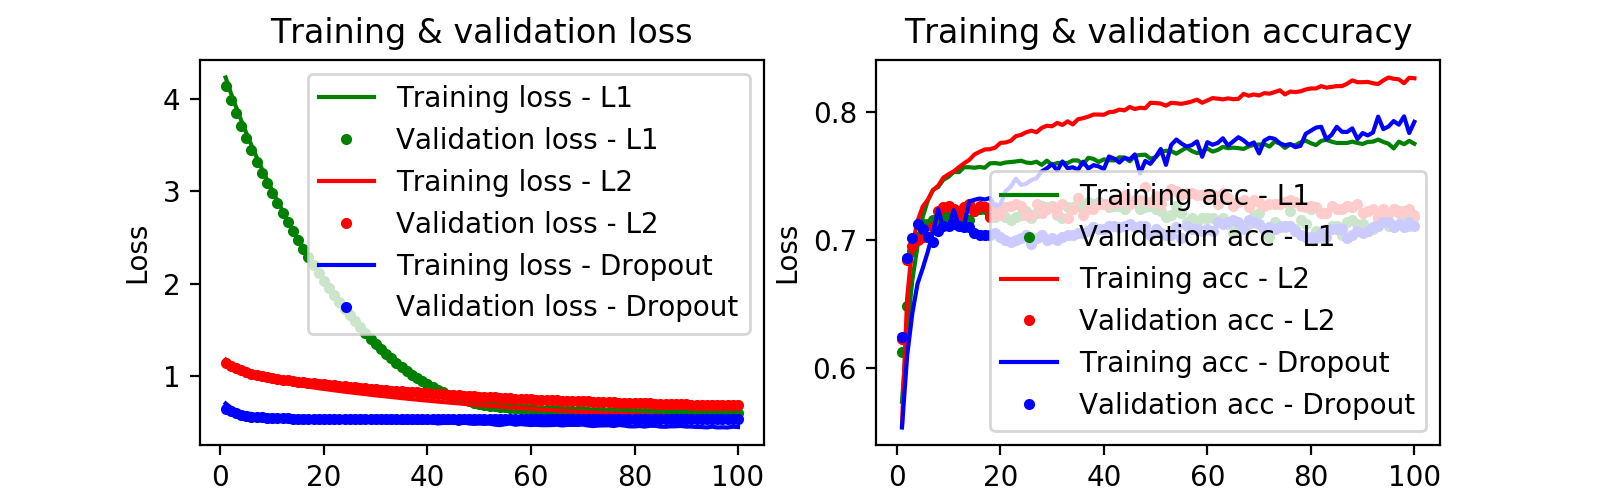

In [115]:
%matplotlib notebook

# L1
loss_values_l1 = history_l1['loss']
val_loss_values_l1 = history_l1['val_loss']
acc_values_l1 = history_l1['acc'] 
val_acc_values_l1 = history_l1['val_acc']
epochs_l1 = range(1, len(loss_values_l1) + 1)

# L2
loss_values_l2 = history_l2['loss']
val_loss_values_l2 = history_l2['val_loss']
acc_values_l2 = history_l2['acc'] 
val_acc_values_l2 = history_l2['val_acc']
epochs_l2 = range(1, len(loss_values_l2) + 1)

# Dropout
loss_values_dropout = history_dropout['loss']
val_loss_values_dropout = history_dropout['val_loss']
acc_values_dropout = history_dropout['acc'] 
val_acc_values_dropout = history_dropout['val_acc']
epochs_dropout = range(1, len(loss_values_dropout) + 1)

plt.figure(figsize = (8,2.5))

plt.subplot(121)
plt.plot(epochs_l1, loss_values_l1, 'g', label='Training loss - L1')
plt.plot(epochs_l1, val_loss_values_l1, 'g.', label='Validation loss - L1')
plt.plot(epochs_l2, loss_values_l2, 'r', label='Training loss - L2')
plt.plot(epochs_l2, val_loss_values_l2, 'r.', label='Validation loss - L2')
plt.plot(epochs_dropout, loss_values_dropout, 'b', label='Training loss - Dropout')
plt.plot(epochs_dropout, val_loss_values_dropout, 'b.', label='Validation loss - Dropout')

plt.title('Training & validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(epochs_l1, acc_values_l1, 'g', label='Training acc - L1')
plt.plot(epochs_l1, val_acc_values_l1, 'g.', label='Validation acc - L1')
plt.plot(epochs_l2, acc_values_l2, 'r', label='Training acc - L2')
plt.plot(epochs_l2, val_acc_values_l2, 'r.', label='Validation acc - L2')
plt.plot(epochs_dropout, acc_values_dropout, 'b', label='Training acc - Dropout')
plt.plot(epochs_dropout, val_acc_values_dropout, 'b.', label='Validation acc - Dropout')

plt.title('Training & validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Initialization
#### He Initialization

In [90]:
model_he = Sequential()
model_he.add(Dense(100, input_shape=(20,), kernel_initializer= "he_normal",
                kernel_regularizer=regularizers.l2(0.005),
                activation='relu'))
model_he.add(Dense(50, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_he.add(Dense(2, activation='sigmoid'))

model_he.compile(optimizer= "sgd" ,loss='binary_crossentropy',metrics=['accuracy'])
he_ini = model_he.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique),verbose=0)

In [91]:
results_train_unique_he = model_he.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_he = model_he.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {}%'.format(round(results_train_unique_he[1]*100),2))
print('Accuracy score for the test set is {}%'.format(round(results_test_unique_he[1]*100),2)) 

700/700 [==============================] - 0s 28us/step
Accuracy score for the training set is 79.0%
Accuracy score for the test set is 76.0%


#### lecun_normal

In [92]:
model_lecun = Sequential()
model_lecun.add(Dense(100, input_shape=(20,), kernel_initializer= "lecun_normal",
                kernel_regularizer=regularizers.l2(0.005),
                activation='relu'))
model_lecun.add(Dense(50, kernel_regularizer=regularizers.l2(0.005), activation='relu'))
model_lecun.add(Dense(2, activation='sigmoid'))

model_lecun.compile(optimizer= "sgd" ,loss='binary_crossentropy',metrics=['accuracy'])
lecun_ini = model_lecun.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique),verbose=0)

In [93]:
results_train_unique_lecun = model_lecun.evaluate(X_train_unique_id, y_train_unique_id)
results_test_unique_lecun = model_lecun.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {}%'.format(round(results_train_unique_lecun[1]*100),2))
print('Accuracy score for the test set is {}%'.format(round(results_test_unique_lecun[1]*100),2)) 

700/700 [==============================] - 0s 30us/step
Accuracy score for the training set is 78.0%
Accuracy score for the test set is 76.0%


### Optimization
#### RMSProp

In [94]:
model_he.compile(optimizer= "rmsprop" ,loss='binary_crossentropy',metrics=['accuracy'])
model_rmsprop = model_he.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique),verbose=0)

In [95]:
results_train_rmsprop = model_he.evaluate(X_train_unique_id, y_train_unique_id)
results_test_rmsprop = model_he.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {}%'.format(round(results_train_rmsprop[1]*100),2))
print('Accuracy score for the test set is {}%'.format(round(results_test_rmsprop[1]*100),2)) 

700/700 [==============================] - 0s 40us/step
Accuracy score for the training set is 86.0%
Accuracy score for the test set is 75.0%


#### Adam

In [96]:
model_he.compile(optimizer= "Adam" ,loss='binary_crossentropy',metrics=['accuracy'])
model_adam = model_he.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique),verbose=0)

In [97]:
results_train_adam = model_he.evaluate(X_train_unique_id, y_train_unique_id)
results_test_adam = model_he.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {}%'.format(round(results_train_adam[1]*100),2))
print('Accuracy score for the test set is {}%'.format(round(results_test_adam[1]*100),2)) 

700/700 [==============================] - 0s 29us/step
Accuracy score for the training set is 88.0%
Accuracy score for the test set is 75.0%


#### Learning Rate Decay

In [98]:
sgd_learning_rate = optimizers.SGD(lr=0.03, decay=0.0001, momentum=0.9)
model_he.compile(optimizer= sgd_learning_rate ,loss='binary_crossentropy',metrics=['accuracy'])
learning_rate_decay = model_he.fit(X_train_unique_id, y_train_unique_id, batch_size=32, 
                 epochs=30, validation_data = (X_val_unique, y_val_unique), verbose = 0)

In [99]:
results_train_lrd = model_he.evaluate(X_train_unique_id, y_train_unique_id)
results_test_lrd = model_he.evaluate(X_test_unique, y_test_unique)

print('Accuracy score for the training set is {}%'.format(round(results_train_lrd[1]*100),2))
print('Accuracy score for the test set is {}%'.format(round(results_test_lrd[1]*100),2)) 

700/700 [==============================] - 0s 25us/step
Accuracy score for the training set is 83.0%
Accuracy score for the test set is 74.0%
